In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# load the data from the database
DB_PATH = Path("../data/engine_data.db") # you need to exit one directory up to access the database with a notebook
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query("SELECT * FROM engine_cycles", conn)
conn.close()
print(f"Loaded {len(df)} rows from the database.")

Loaded 20631 rows from the database.


## Random Forest Classifier: What It’s Doing

This model is trained to predict whether an engine is likely to fail within the next 30 cycles (`label_30 = 1`) or not (`label_30 = 0`). I defined a `label_30` column in the dataset to indicate this. 

After training, we evaluate it on a hold-out test set (20% of the data) to see how well it generalizes to unseen engine behavior.


In [6]:
# Preprocess the data
X = df.drop(columns=['unit', 'cycle', 'ttf', 'label_30']) 
y = df['label_30']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RFC
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3543
           1       0.89      0.83      0.86       584

    accuracy                           0.96      4127
   macro avg       0.93      0.91      0.92      4127
weighted avg       0.96      0.96      0.96      4127



## Confusion Matrix: Interpreting Model Behavior

This matrix compares the models predictions with the actual outcomes:

- Top-left: True Negatives (TN) – correctly predicted not-at-risk
- Top-right: False Positives (FP) – predicted at-risk, but it wasnt (overcautious)
- Bottom-left: False Negatives (FN) – predicted safe, but it failed (critical misses)
- Bottom-right: True Positives (TP) – correctly predicted at-risk

Our goal is to minimize **false negatives**, since missing an at-risk engine is more dangerous than over-predicting.


<Figure size 600x600 with 0 Axes>

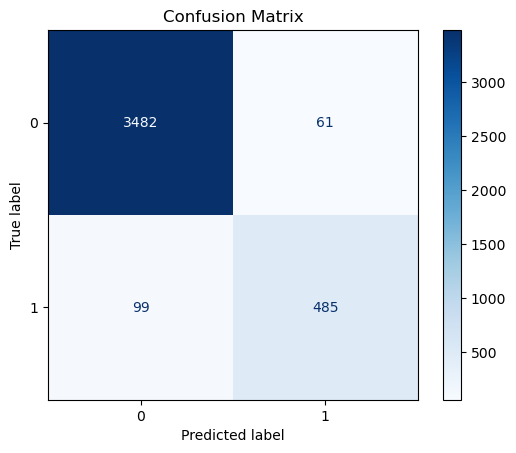

In [13]:
# construct confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

## What the Model Relies On

This bar chart shows which input features (sensor readings, op settings) contributed most to the models decision-making.

It helps identify:
- Which sensors are strong indicators of degradation
- Whether engineered features like rolling averages add value

This also helps with explainability and maybe a potential sensor reduction in production systems.


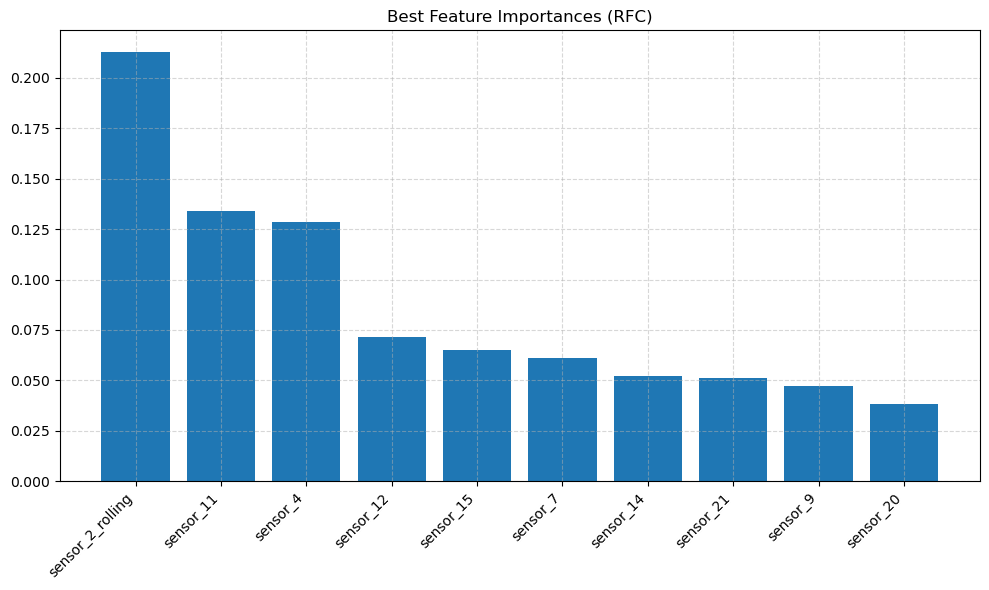

In [16]:
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Best Feature Importances (RFC)")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), feature_names[indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [19]:
# Save the model
MODEL_DIR = Path("../model/artifacts")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(model, MODEL_DIR / "rf_classifier.pkl")
print("Model saved to", MODEL_DIR / "rf_classifier.pkl")

Model saved to ..\model\artifacts\rf_classifier.pkl
